# Load DeepFly3D Data

In [39]:
%load_ext autoreload
%autoreload 2
from load import *
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
       'out_dir'        : './out',
       'train_subjects' : [1],
       'test_subjects'  : [6,7],
       'actions'        : ['all'],
       'cam_id'         : [2,5]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 2D data
train_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, _, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, _, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [40]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, rcams_train=rcams_train, rcams_test=rcams_test, 
      roots=par['roots'], target_sets=par['targets'], in_dim=2, out_dim=par["out_dim"], out_dir=par['out_dir'])

[main.py:91]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/fly_tether/out/stat_2d.pth.tar.
[main.py:115]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/fly_tether/out/stat_3d.pth.tar.
[main.py:143]:INFO:Starting training model
[main.py:152]:DEBUG:
==================Options=================
[main.py:153]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:154]:DEBUG:================================

Epoch 0 | Loss Test 0 | Loss Train 0.31063|: 100%|██████████| 3291/3291 [00:44<00:00, 73.98it/s]
/home/user/Desktop/LiftPose3D/liftpose/lifter/test.py:95: RuntimeWarning: Mean of empty slice
  joint_err = np.nanmean(all_dist, axis=0)
Epoch 1 | Loss Test 0.053558 | Loss Train 0.10089|: 100%|██████████| 3291/3291 [00:43<00:00, 75.13it/s] 
Epoch 2 | Loss Test 0.044599 | Loss Train 0.091078|: 100%|██████████| 3291/3291 [00:41<00:00, 79.47it/s] 
Epoch 3 | Loss Test 0.042222 | Loss Train 0.086015|: 100%|██████████| 3291/3291 [00:42<00:00, 78.07it/s] 
Epoch 4 | Loss Test 0.037939 | Loss Train 0.082773|: 100%|██████████| 3291/3291 [00:42<00:00, 76.65it/s] 
Epoch 5 | Loss Test 0.03778 | Loss Train 0.080006|: 100%|██████████| 3291/3291 [00:41<00:00, 78.41it/s] 
Epoch 6 | Loss Test 0.034813 | Loss Train 0.077926|: 100%|██████████| 3291/3291 [00:42<00:00, 76.68it/s] 
Epoch 7 | Loss Test 0.033929 | Loss Train 0.076083|: 100%|██████████| 3291/3291 [00:44<00:00, 74.08it/s]
Epoch 8 | Loss Test 0.03313

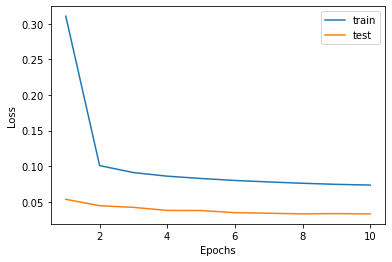

In [41]:
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [42]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:159]:INFO:starting testing in path: ./out
[lift.py:54]:INFO:total params: 4.27M
[lift.py:60]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:68]:INFO:ckpt loaded (epoch: 8 | err: 0.36680230498313904)
[lift.py:106]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/fly_tether/out/test_results.pth.tar


# Visualize Predictions

In [49]:
from liftpose.postprocess import load_test_results
test_3d_gt, test_3d_pred, test_3d_inp = load_test_results(par['out_dir'])

In [53]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=200, azim=60)

t = 900
plot_pose_3d(ax, test_3d_gt[t], 
            test_3d_pred[t], 
            test_3d_inp[t],
            par["out_dim"], 
            np.array(par_data["vis"]["bones"][:12]), 
            par_data["vis"]["limb_id"], 
            par_data["vis"]["colors"])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(15, 3) (15, 2) (15, 3)
